In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
from geotext import GeoText

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *
from tmv_app.views import *
import scipy.stats as st
import itertools

now=datetime.datetime.now()

django.db.connection.close()

In [2]:
q = Query.objects.get(pk=8843)
p = q.project
tag = Tag.objects.get(pk=6076)

In [3]:
def compare_tag(tag,p):
    
    docids = DocOwnership.objects.filter(tag=tag).values_list('doc__id', flat=True)
    docs = Doc.objects.filter(pk__in=docids)
    if not DocOwnership.objects.filter(doc__in=docs, query=q,relevant__gt=0, tag=tag).exists():
        return pd.DataFrame()

    cats = Category.objects.filter(project=p).exclude(name__icontains="hidden>")
    df = pd.DataFrame.from_dict(
        DocUserCat.objects.filter(
            category__in=cats,
            doc__in=docs
        ).values(
            'doc__id',
            'category__name',
            'category__level',
            'user__username'
        )
    )
    df['category__level'] = df['category__level'].astype(str)
    df['cat'] = df[['category__level','category__name','user__username']].apply(lambda x: ' - '.join(x), axis=1)
    df['val'] = 1
    
    df['cname'] = df[['category__level','category__name']].apply(lambda x: ' - '.join(x), axis=1)
    
    dudf_wide = df[['doc__id','user__username','cname','val']].pivot_table(index=['doc__id','user__username'],columns="cname", values="val").fillna(0)
    dudf_wide_r = dudf_wide.reset_index()
    dudf_wide_r.columns = ["doc__id",'user__username'] + list(dudf_wide.columns)
    dudf_expanded = dudf_wide_r.melt(id_vars=["doc__id","user__username"]).sort_values(['doc__id','variable'])
    dudf_expanded['mean'] = dudf_expanded.groupby(['doc__id','variable']).transform('mean')
    dudf_expanded = dudf_expanded.rename(columns={
        "doc__id":"doc_id",
        "variable":"category",
        "user__username":"user"
    })
    
    wide_df = (df[['doc__id','cat','val']]
           .drop_duplicates()
           .pivot(index='doc__id',columns="cat",values='val')
           .fillna(0)
          )
    cs = wide_df.columns
    wide_df['doc_id'] = wide_df.index
    wide_df = wide_df.reset_index(drop=True)
    
    do_df = pd.DataFrame.from_dict(
        DocOwnership.objects.filter(doc__in=docs, query=q,relevant__gt=0).values(
            'doc__id',
            'user__username',
            'relevant'
        )
    )
    do_df = (
        do_df.drop_duplicates(['doc__id','user__username'])
        .pivot(index='doc__id',columns="user__username",values="relevant")
    )
    rs = []
    for c in do_df.columns:
        do_df = do_df.rename(columns={c: f'0 - relevant - {c}'})
        rs.append(f'0 - relevant - {c}')
    do_df['doc_id'] = do_df.index
    do_df = do_df.reset_index(drop=True)
    
    doc_df = pd.DataFrame.from_dict(
        Doc.objects.filter(pk__in=docs).values(
            'id','title','content'
        )
    ).rename(columns={"id":"doc_id"})
    
    dudf_expanded = pd.merge(dudf_expanded,doc_df, how="outer")[["doc_id","title","content","user","category","value","mean"]]
    
    df = pd.merge(doc_df,pd.merge(wide_df,do_df,how="outer"))[["doc_id","title","content"]+list(rs)+list(cs)]

    #df = df.loc[:,(df.sum(axis=0) != 0)]
    

    
    df.to_csv(f'{tag.title}_comparison.csv', index=False)

    writer = pd.ExcelWriter(f'{tag.title}_comparison.xlsx', engine='xlsxwriter')
    df.to_excel(writer, index=False, sheet_name='comparison')
    dudf_expanded.to_excel(writer, index=False, sheet_name='by_cat_comparison')
    workbook = writer.book
    worksheet = writer.sheets['comparison']
    wrap_format = workbook.add_format({'text_wrap': True})
    worksheet.set_column('D:ZZ', 20)
    worksheet.set_column('C:C', 80, wrap_format)
    worksheet.set_column('B:B', 30, wrap_format)

    for col_num, value in enumerate(df.columns.values):
        worksheet.write(0,col_num,value.split('@')[0],wrap_format)

    for i,row in df.iterrows():
        try:
            worksheet.set_row(i+1,15+15*len(row['content'])//150)
        except:
            worksheet.set_row(i+1,15)
    worksheet.set_row(0, 40)
    worksheet.freeze_panes(1,3)
    
    worksheet = writer.sheets['by_cat_comparison']
    
    worksheet.set_column('D:ZZ', 15)
    worksheet.set_column('C:C', 40)
    worksheet.set_column('B:B', 40, wrap_format)
    worksheet.set_column('D:E', 40, wrap_format)
    
    for i,row in dudf_expanded.iterrows():
        worksheet.set_row(i+1,17+17*len(row['title'])//60)
        
    worksheet.conditional_format(f'G1:G{i+1}', {
        'type': '3_color_scale',
        'min_value': 0,
        'mid_value': 0.5,
        'max_value': 1
    })
    
    writer.save()
    
    return df

df = compare_tag(tag, p)
print(df.shape)
df.head()

(80, 231)


,doc_id,title,content,0 - relevant - ceposadap@gmail.com,0 - relevant - doebbeling@mcc-berlin.net,0 - relevant - galm,0 - relevant - lucy.banisch@icloud.com,0 - relevant - muef,0 - relevant - vasudevan@mcc-berlin.net,10 - 3. Quantitative - ceposadap@gmail.com,...,9 - 0. Ex-post - galm,9 - 0. Ex-post - lucy.banisch@icloud.com,9 - 0. Ex-post - muef,9 - 0. Ex-post - vasudevan@mcc-berlin.net,9 - 1. Ex-ante - ceposadap@gmail.com,9 - 1. Ex-ante - doebbeling@mcc-berlin.net,9 - 1. Ex-ante - galm,9 - 1. Ex-ante - lucy.banisch@icloud.com,9 - 1. Ex-ante - muef,9 - 1. Ex-ante - vasudevan@mcc-berlin.net
0,1549362,Human Rights Discourse in the Sustainable Deve...,Our commentary on Forman et al paper explores ...,NaN,NaN,2.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3778807,When salient science is not enough to advance ...,Increased social and environmental vulnerabili...,NaN,NaN,NaN,NaN,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,456098,Making the National Adaptation Programme of Ac...,"Recently, tree planting has become popular und...",NaN,NaN,NaN,NaN,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,485120,Carbon dioxide enrichment technology: Open top...,There are many technical difficulties in condu...,NaN,NaN,1.0,1.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1783714,"CLIMATE CHANGE, RISK AND STRATEGIES FOR ADAPTA...",Environmental quality and adaptation to climat...,NaN,NaN,1.0,1.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
django.db.connection.close()

tag = Tag.objects.filter(query__project=p).order_by('-pk')[1]

print(tag.title)

dos = DocOwnership.objects.filter(tag=tag, relevant__gt=0)

doc_ids = set(dos.values_list('doc__id',flat=True))

do_df = pd.DataFrame.from_dict(
    dos.values('doc__id','doc__title','doc__content','user__username','relevant')
)
do_df.loc[do_df['relevant']==0,'val'] = np.NaN
do_df.loc[do_df['relevant']==1,'val'] = 1
do_df.loc[do_df['relevant']==2,'val'] = 0
do_df.loc[do_df['relevant']==3,'val'] = -1
do_df.head()

Representative random sample 2


,doc__id,doc__title,doc__content,user__username,relevant,val
0,2151551,Global relative species loss due to first-gene...,The global demand for biofuels in the transpor...,ceposadap@gmail.com,1,1.0
1,3844049,An alternative explanation of the persistent l...,"Worldwide, electric vehicles (EVs) are regarde...",ceposadap@gmail.com,1,1.0
2,358287,Timberline structure and limited tree recruitm...,"Background: Pyrenean timberlines, lowered to v...",ceposadap@gmail.com,3,-1.0
3,3836623,Columnar Asian dust particle properties observ...,Multi-year AERONET sun/sky radiometer data (20...,ceposadap@gmail.com,2,0.0
4,2522429,Advanced estimation and mitigation strategies:...,"Methane, one of the important greenhouse gas, ...",ceposadap@gmail.com,1,1.0


In [ ]:
django.db.connection.close()

tag = Tag.objects.filter(query__project=p).order_by('-pk').first()

print(tag.title)

dos = DocOwnership.objects.filter(tag=tag, relevant__gt=0)

doc_ids = set(dos.values_list('doc__id',flat=True))

do_df = pd.DataFrame.from_dict(
    dos.values('doc__id','doc__title','doc__content','user__username','relevant')
)
do_df.loc[do_df['relevant']==0,'val'] = np.NaN
do_df.loc[do_df['relevant']==1,'val'] = 1
do_df.loc[do_df['relevant']==2,'val'] = 0
do_df.loc[do_df['relevant']==3,'val'] = -1
do_df.head()

cats = Category.objects.filter(project=p).exclude(name__icontains="hidden>")
df = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        category__in=cats,
        doc__in=doc_ids
    ).values(
        'doc__id',
        'doc__title',
        'doc__content',
        'category__name',
        'category__level',
        'user__username',
        'countries__name',
        'texts__name'
    )
)
df = df[
    (df[['doc__id','user__username']].apply(tuple, axis=1).isin(do_df[['doc__id','user__username']].apply(tuple, axis=1))) | 
    (df['user__username']=="Auto")
]
df['category__level'] = df['category__level'].astype(str)
df['cat'] = df[['category__level','category__name','user__username']].apply(lambda x: ' - '.join(x), axis=1)
df['val'] = 1
df.loc[~pd.isna(df['countries__name']),'val'] = df.loc[~pd.isna(df['countries__name']),'countries__name']
df.loc[~pd.isna(df['texts__name']),'val'] = df.loc[~pd.isna(df['texts__name']),'texts__name']

df['Category Name'] = df[['category__level','category__name']].apply(lambda x: ' - '.join(x), axis=1)

cats = df['Category Name'].unique()

df.head()

In [ ]:
do_df['Category Name'] = "0 - relevant"

merged_df = pd.concat([
    df[['doc__id','doc__title','doc__content','user__username','Category Name','val']],
    do_df[['doc__id','doc__title','doc__content','user__username','Category Name','val']]
])
merged_df.tail()

In [ ]:
# fill tag values with 0s where they have been rated
def concat(x):
    return ", ".join(x)
dudf_wide = (merged_df[['doc__id','doc__title','doc__content','user__username','Category Name','val']]
             .pivot_table(index=['doc__id','doc__title','doc__content','user__username'],columns="Category Name", values="val", aggfunc=np.sum)
             #.fillna(0)
            ).reset_index()

cats = [x for x in cats if x in dudf_wide.columns]

dudf_wide[cats] = dudf_wide[cats].fillna(0)

policy_columns=[x for x in dudf_wide.columns if re.match("^3",x)]
print(policy_columns)
post_policy_columns=[x for x in dudf_wide.columns if re.match("^[4-9]",x) or re.match("^[0-9]{2}",x)]
dudf_wide.loc[dudf_wide['3 - 0. Not policy related']==1,post_policy_columns] = np.NaN
dudf_wide.loc[dudf_wide[policy_columns].sum(axis=1,min_count=1)==0,post_policy_columns] = np.NaN


dudf_wide.loc[dudf_wide['3 - 0. Not policy related']==1]

dudf_wide.head()

In [ ]:
xdf = dudf_wide.melt(id_vars=['doc__id','doc__title','doc__content','user__username'])
xdf.head(15)

In [ ]:
dudf_wide = (xdf[['doc__id','doc__title','doc__content','user__username','Category Name','value']]
             .pivot_table(index=['doc__id','doc__title','doc__content','Category Name'],columns="user__username", values="value", aggfunc=lambda x: x.sum(min_count=1))
             #.fillna(0)
            ).reset_index()

print(dudf_wide.columns)

print(dudf_wide.shape)

#dudf_wide[dudf_wide['doc__id']==3280458].head(20)
dudf_wide.head()

In [ ]:
import pandas.io.formats.excel
from nltk.metrics.agreement import AnnotationTask

pandas.io.formats.excel.ExcelFormatter.header_style = None

dudf_wide = (xdf[['doc__id','doc__title','doc__content','user__username','Category Name','value']]
             .pivot_table(index=['doc__id','doc__title','doc__content','Category Name'],columns="user__username", values="value", aggfunc=lambda x: x.sum(min_count=1))
             #.fillna(0)
            )

def multi_kappa(group):

    annotations = []
    for coder in group.columns:
        annotations += [(coder,i, v) for i,v in enumerate(group.dropna()[coder].values)]

    t = AnnotationTask(annotations)
    cols = ["Fleiss Kappa"]
    try:
        vals = [t.multi_kappa()]
    except:
        vals = [np.NaN]
        
    for comb in itertools.combinations(group.columns,2):
        annotations = []
        for coder in comb:
            annotations += [(coder,i, v) for i,v in enumerate(group[list(comb)].dropna()[coder].values)]
        t = AnnotationTask(annotations)
        cols.append(" - ".join([x.split("@")[0] for x in comb]))
        try:
            vals.append(round(t.weighted_kappa(),2))
        except:
            vals.append(np.NaN)
        
    return pandas.Series({cols[i]: vals[i] for i in range(len(vals))})

writer = pd.ExcelWriter(f'{tag.title}_comparison.xlsx', engine='xlsxwriter')

kappa_data = dudf_wide.groupby('Category Name').apply(multi_kappa)

kappa_data.to_excel(writer, sheet_name='Agreement')

dudf_wide['agreement'] = np.where(dudf_wide.nunique(axis=1)>1,0,1)
#dudf_wide=dudf_wide[dudf_wide['agreement']==0]

dudf_wide.reset_index().to_excel(writer, sheet_name='comparison', index=False)

workbook = writer.book
worksheet = writer.sheets['comparison']
wrap_format = workbook.add_format({'text_wrap': True})
worksheet.set_column('D:ZZ', 20)
worksheet.set_column('C:C', 90, wrap_format)
worksheet.set_column('B:B', 30, wrap_format)
worksheet.set_column('D:D', 30, wrap_format)

rh = 18
for i,row in dudf_wide.reset_index().iterrows():
    try:
        worksheet.set_row(i+1,rh+rh*len(row['Category Name'])//40)
    except:
        worksheet.set_row(i+1,rh)

worksheet.freeze_panes(1,1)

colors = ['#d53e4f','#fc8d59','#fee08b','#e6f598','#99d594','#3288bd']
thresholds = [-1.0, 0.0, 0.2, 0.4, 0.6, 0.8]
colors.reverse()
thresholds.reverse()
worksheet = writer.sheets['Agreement']

ncols = kappa_data.shape[1]
if ncols//26>0:
    lcolumn = chr(65+ncols//26)+chr(65+ncols%26)
else:
    lcolumn = chr(65+ncols)

for c, t in zip(colors, thresholds):
    print(f"{t:.2f}")
    nformat = workbook.add_format({'bg_color': c})

    worksheet.conditional_format(f'B2:{lcolumn}{kappa_data.shape[0]+1}', {
        'type': 'cell',
        'criteria': '>',
        'value': f"{t:.2f}",
        'format': nformat
    })
    
worksheet.set_column('A:A', 60, wrap_format)
worksheet.set_column(f'B:{lcolumn}',20)
worksheet.freeze_panes(1,1)

writer.save()

In [ ]:
dudf_wide.head()

,id,doc_id,docpar_id,utterance_id,tweet_id,document_linked,utterance_linked,title_only,full_text,project_id,user_id,query_id,tag_id,order,relevant,date,start,finish,coded
0,1630937,2647339,None,None,None,True,False,False,False,None,1,8843,5937,NaN,3,2021-01-26 13:49:20.134805+00:00,None,2021-01-27 16:00:09.098452+00:00,1
1,1630944,643753,None,None,None,True,False,False,False,None,1,8843,5937,NaN,1,2021-01-26 13:49:22.183363+00:00,None,2021-01-27 16:01:34.019005+00:00,1
2,1630951,273713,None,None,None,True,False,False,False,None,1,8843,5937,NaN,1,2021-01-26 13:49:24.947117+00:00,None,2021-01-27 16:03:18.194592+00:00,1
3,1630958,444393,None,None,None,True,False,False,False,None,1,8843,5937,NaN,1,2021-01-26 13:49:28.276706+00:00,None,2021-01-27 16:04:54.931507+00:00,1
4,1630965,1727089,None,None,None,True,False,False,False,None,1,8843,5937,NaN,3,2021-01-26 13:49:30.630256+00:00,None,2021-01-27 16:05:25.882416+00:00,1


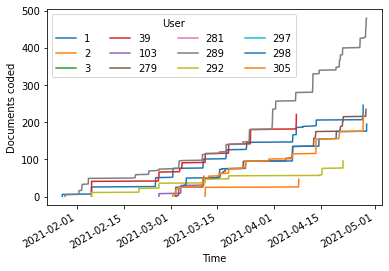

In [7]:
django.db.connection.close()
tags = Tag.objects.filter(query=tag.query)
df = pd.DataFrame.from_dict(DocOwnership.objects.filter(tag__in=tags).order_by('finish').values())
df['coded'] = np.where(df['relevant']>0,1,0)

fig, ax = plt.subplots()

for name, group in df.groupby('user_id'):
    group = group[~pd.isna(group['finish'])].sort_values('finish').set_index('finish')
    group['cumsum'] = group['coded'].cumsum()
    group['cumsum'].plot(label=name)
    #ax.plot(group.sort_values('finish')['finish'], group.sort_values('finish')['coded'].cumsum())

df.head()

l = ax.legend(ncol=4)
l.set_title('User')
ax.set_xlabel('Time')
ax.set_ylabel('Documents coded')
df.head()

Text(0, 0.5, 'Documents coded')

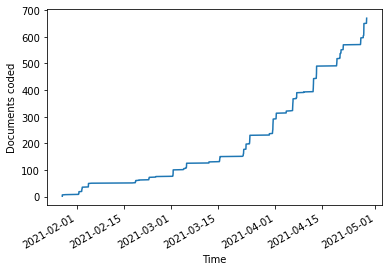

In [8]:
nd = df[~df.duplicated('doc_id')].sort_values('finish').set_index('finish')
fig, ax = plt.subplots()
nd['cumsum'] = nd['coded'].cumsum()
nd['cumsum'].plot()

ax.set_xlabel('Time')
ax.set_ylabel('Documents coded')

In [9]:
df.head()

,id,doc_id,docpar_id,utterance_id,tweet_id,document_linked,utterance_linked,title_only,full_text,project_id,user_id,query_id,tag_id,order,relevant,date,start,finish,coded
0,1630937,2647339,None,None,None,True,False,False,False,None,1,8843,5937,NaN,3,2021-01-26 13:49:20.134805+00:00,None,2021-01-27 16:00:09.098452+00:00,1
1,1630944,643753,None,None,None,True,False,False,False,None,1,8843,5937,NaN,1,2021-01-26 13:49:22.183363+00:00,None,2021-01-27 16:01:34.019005+00:00,1
2,1630951,273713,None,None,None,True,False,False,False,None,1,8843,5937,NaN,1,2021-01-26 13:49:24.947117+00:00,None,2021-01-27 16:03:18.194592+00:00,1
3,1630958,444393,None,None,None,True,False,False,False,None,1,8843,5937,NaN,1,2021-01-26 13:49:28.276706+00:00,None,2021-01-27 16:04:54.931507+00:00,1
4,1630965,1727089,None,None,None,True,False,False,False,None,1,8843,5937,NaN,3,2021-01-26 13:49:30.630256+00:00,None,2021-01-27 16:05:25.882416+00:00,1


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'frequency')

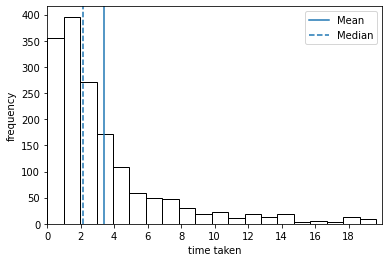

In [10]:
fig, ax = plt.subplots()

df['start'] = df['finish'].shift(1)
df['time'] = df['finish'] - df['start']
df['time'] = df['time'].astype('timedelta64[s]')
#maxtime = 600
maxtime = 1200
df.loc[df['time']>maxtime,'time'] = np.NaN
df.loc[df['time']<0,'time'] = np.NaN

ax.hist(df['time'],bins=20,fill=False)

ticksize = (60*2)
nticks = maxtime//ticksize
minticks, minticklabels = zip(*[(i*ticksize,i*2) for i in range(nticks)])

values = df.sort_values('time').loc[pd.notna(df['time']),'time']

mean = np.mean(values)

median = np.median(values)

ax.axvline(mean, label="Mean")

ax.axvline(median, ls="--", label="Median")

ax.legend()

ax.set_xticks(minticks)
ax.set_xticklabels(minticklabels)
ax.set_xlim(0,maxtime)

ax.set_xlabel('time taken')

ax.set_ylabel('frequency')

NameError: name 'i' is not defined

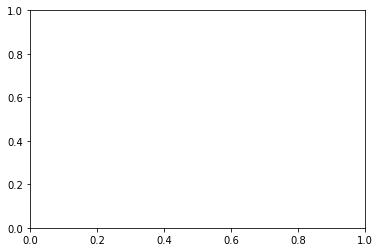

In [11]:


fig, ax = plt.subplots()

group = df

ticksize = (60*2)
nticks = maxtime//ticksize
minticks, minticklabels = zip(*[(i*ticksize,i*2) for i in range(nticks)])

values = group.sort_values('time').loc[pd.notna(group['time']),'time']
kernel = st.gaussian_kde(values, bw_method=0.03)
ax.plot(
    kernel.dataset.ravel(),
    kernel.pdf(kernel.dataset),
    #label=f"{name} (| mean)",
    color=f"C{i}"
)
mean = np.mean(values)
ax.plot(
    [mean,mean],
    [0,kernel.pdf(mean)],
    color=f"C{i}"
)

ax.set_xticks(minticks)
ax.set_xticklabels(minticklabels)
ax.set_xlim(0,maxtime)

ax.set_xlabel('Time taken (minutes)')

ax.legend()

fig.tight_layout()

In [ ]:
TextFree.objects.filter(name__icontains="Year Plan").last()